In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

In [3]:
from pathlib import Path
import os

from omegaconf import OmegaConf
import anndata as ad
import scanpy as sc
import scvi
import pandas as pd
import pyreadr

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from evaluation.visualizations import make_confusion_matrix

from data_loading.utils import load_dataframe_from_file, merge_labels_to_adata
from sc_classification.var_genes import normalize_and_choose_genes, shuang_genes_to_keep
from io_utils import generate_path_in_output_dir

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
config_path = Path(repo_dir, 'config.yaml')
conf = OmegaConf.load(config_path)

In [6]:
from datetime import date
ts_iso = date.today().isoformat()

figures_dir = Path(conf.outputs.output_dir, "figures", ts_iso)

## data loading

### from pp_adata

#### var genes

In [10]:
adata_path = Path(conf.outputs.output_dir, conf.outputs.processed_adata_file_name)
adata_pp = ad.read_h5ad(adata_path)
adata_pp

AnnData object with n_obs × n_vars = 422202 × 50803
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Method', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [11]:
shunag_var_genes = 'MARS_SPID_combined' # MARS_SPID_combined, MARS_SPID_common or None
genes_to_keep = shuang_genes_to_keep(genes_names=adata_pp.var_names, flavor=shunag_var_genes)

In [12]:
adata_pp.layers["counts"] = adata_pp.X.copy()  # preserve counts (needed for normalize_and_choose_genes with if suret_vs flavor + SCVI)
adata_for_clustering = normalize_and_choose_genes(adata_pp, conf, genes_to_keep=genes_to_keep, min_mean=0.02, max_mean=3, min_disp=0.5)
adata_for_clustering

AnnData object with n_obs × n_vars = 422202 × 3862
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Method', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

#### annotations

In [ ]:
label_col = "Populations"
super_pop = "super_Population"

In [32]:
cells_dir = "/home/labs/amit/noamsh/data/mm_2023/cells"
all_annotation_path = Path(cells_dir, "cells_snnotation_20231110.csv")
all_labels = pd.read_csv(all_annotation_path)
# all_labels

In [26]:
adata_annot_pred_path = Path(conf.outputs.output_dir, 'adata_with_scvi_annot_pred_2024-03-26.h5ad')
adata_annot_pred = ad.read_h5ad(adata_annot_pred_path)
adata_annot_pred

AnnData object with n_obs × n_vars = 422202 × 3862
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Method', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Populations', 'super_Population', 'cID', '_scvi_batch', '_scvi_labels', 'new_samples', 'Predicted'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Method_colors', 'Populations_colors', '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'new_samples_colors', 'super_Population_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [37]:
all_labels_with_pred = adata_annot_pred.obs[[label_col, super_pop, "Predicted"]].reset_index(names="cID")
# all_labels_with_pred

In [40]:
adata_for_clustering.obs = adata_for_clustering.obs.drop(columns=all_labels_with_pred.columns, errors="ignore")

In [41]:

adata_for_clustering = merge_labels_to_adata(adata_for_clustering, all_labels_with_pred, 
                                            col_in_adata_to_merge_by="index", 
                                            cols_in_labels_df_to_merge_by="cID", 
                                            cols_to_validate_not_empty=None, labels_col_names_to_merge=[label_col, super_pop])
adata_for_clustering

AnnData object with n_obs × n_vars = 422202 × 3862
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Method', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_tme', '_scvi_batch', '_scvi_labels', 'Populations', 'super_Population', 'cID'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'Method_colors', 'Populations_colors', 'super_Population_colors', 'Disease_colors'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [15]:
is_tme = "is_tme"
adata_for_clustering.obs[is_tme] = ((~adata_for_clustering.obs[label_col].isna()) & (adata_for_clustering.obs[label_col] != 'PC')).astype("category")

#### scVI model

In [17]:
scvi.model.SCVI.setup_anndata(
    adata_for_clustering,
    layer="counts",
    batch_key="Method",
)

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [18]:
if shunag_var_genes != 'None':
    model_name = f"{conf.outputs.scvi_model_name}_{shunag_var_genes}_genes"
else:
    model_name = conf.outputs.scvi_model_name

model_path = os.path.join(conf.outputs.output_dir,  model_name + "_2024-03-27")
model = scvi.model.SCVI.load(model_path, adata=adata_for_clustering)
model

INFO     File /home/labs/amit/noamsh/repos/MM_2023/outputs/scvi_model_MARS_SPID_combined_genes_2024-03-27/model.pt 
         already downloaded                                                                                        


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

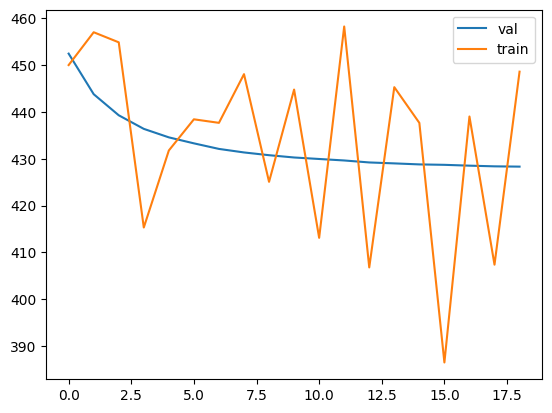

In [19]:
import matplotlib.pyplot as plt
plt.plot(model.history['validation_loss'], label="val")
plt.plot(model.history['train_loss_step'], label="train")
plt.legend()
plt.show()

In [20]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata_for_clustering.obsm[SCVI_LATENT_KEY] = latent
latent.shape

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


(422202, 10)

#### negborhood_graph

In [21]:
# new_neigbros_key = 'scvi_neighbors'
# adata_for_clustering = adata_for_clustering[adata_for_clustering.obs[super_pop] == "CD45"]
sc.pp.neighbors(adata_for_clustering, use_rep=SCVI_LATENT_KEY, n_neighbors=30) # key_added=new_neigbros_key
sc.tl.umap(adata_for_clustering, min_dist=0.3)

#### save results

In [22]:
from datetime import date
ts_iso = date.today().isoformat()
adata_with_annot_and_scvi_path = Path(conf.outputs.output_dir, f"adata_with_annot_and_scvi_{ts_iso}.h5ad")
adata_for_clustering.write(adata_with_annot_and_scvi_path)

### load - from adata with annotation and scvi latent representation

In [29]:
load_ts_iso = "2024-08-18"
data_version = "20240813"

adata_for_clustering = ad.read_h5ad(generate_path_in_output_dir(conf, conf.outputs.inferred_missing_annotation_file_name,
                                                 with_version=data_version, with_date_timestamp=load_ts_iso))
adata_for_clustering

AnnData object with n_obs × n_vars = 531506 × 3862
    obs: 'Unnamed: 0', 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_PC_in_neighborhood', 'count_of_CD45_in_neighborhood', 'pc_with_tme_environment'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'pc', 'umap'
    obsm: 'X_scVI', 'X_umap', 'pc_X_scVI'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'pc_connectivities', 'pc_distances'

## raw data report

In [30]:
from clinical_predictions.clinical_data_loading import load_and_process_clinical_data
from data_loading.utils import get_updated_disease_col

new_hospital_path = Path('/home/labs/amit/noamsh/data/mm_2023/clinical_prediction/Anonymized_CRF_BP_01082024.xlsx')
clinical_data_df = load_and_process_clinical_data(new_hospital_path, code_lower_case=True, get_hospital_stage=True, 
                                                  get_post_treatment=False, get_treatment_history=False)
clinical_data_df['Disease Stage Hospital'].value_counts()

Disease Stage Hospital
RRMM              171
non_naive_NDMM     33
NDMM               19
MGUS               15
AL                 13
SMM                12
Name: count, dtype: int64

In [31]:
adata_for_clustering.obs['Hospital.Code'] = adata_for_clustering.obs['Hospital.Code'].str.lower()
adata_for_clustering.obs['Biopsy.Sequence'] = adata_for_clustering.obs['Biopsy.Sequence'].astype(int)
merged = adata_for_clustering.obs.merge(clinical_data_df, how='left', left_on=['Hospital.Code', 'Biopsy.Sequence'],
                                       right_on=['Code', 'Biopsy sequence No.'])

merged['updated_Disease'] = get_updated_disease_col(merged, 
                      disease_col='Disease', hospital_disease_col='Disease Stage Hospital',
                      update_non_naive_NDMM=False, remove_PRMM=True)

merged.index = adata_for_clustering.obs_names
adata_for_clustering.obs['Disease']  = merged['updated_Disease']

In [32]:
Disease_patients_count = adata_for_clustering.obs.groupby('Disease')['Hospital.Code'].nunique()

print(f"cells - over all: , after: {len(adata_for_clustering.obs_names)}, dropped: ") # from logs
print(f"number of patients: {len(adata_for_clustering.obs['Hospital.Code'].unique())}")
print(Disease_patients_count)

cells - over all: , after: 531506, dropped: 
number of patients: 357
Disease
AL                 13
Healthy            55
MGUS               16
MM_Unknown          4
NDMM               26
RRMM              202
SMM                13
nan                 1
non_naive_NDMM     36
Name: Hospital.Code, dtype: int64


## view neighborhood graph

In [11]:
label_col = conf.annotation.cell_type_column
super_pop = conf.annotation.major_cell_type_column

In [13]:
adata_for_clustering.obs["Population"] = adata_for_clustering.obs[label_col].apply(lambda x: x if x not in ["Healthy", "Malignant"] else "PC")
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.umap(adata_for_clustering, neighbors_key="neigbros", color=['Method', "Population"],
               ncols=1, legend_loc="on data", na_in_legend=False, show=False)
    plt.savefig(Path(figures_dir, "all_umap_annotation_method.pdf"), bbox_inches="tight", format="pdf")
        

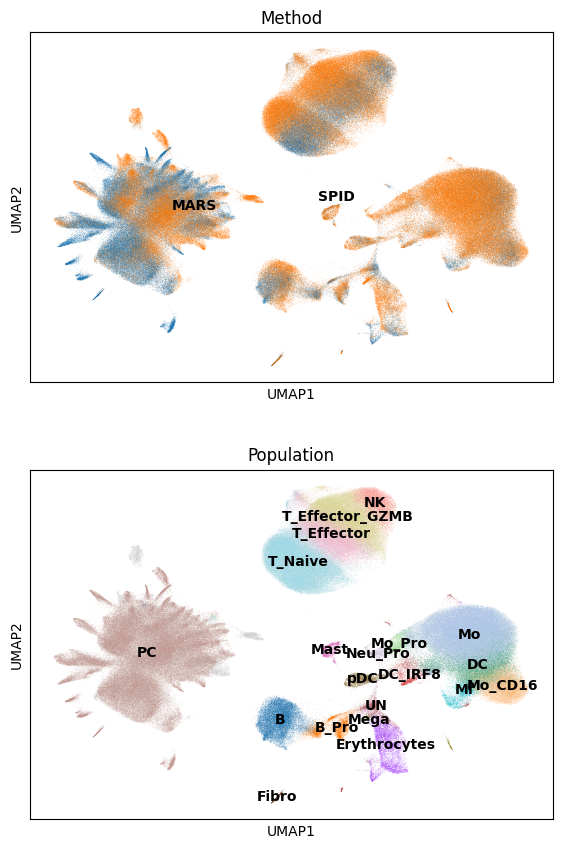

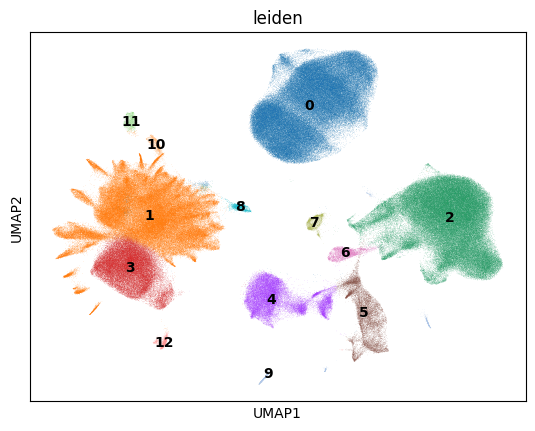

In [14]:
sc.pl.umap(adata_for_clustering, neighbors_key="neigbros", color=["leiden"],
               ncols=1, legend_loc="on data", na_in_legend=False)

In [15]:
# adata = flo_rebalanced_CD45_adata[~ flo_rebalanced_CD45_adata.obs[[label_col]].isna().any(axis=1), :]
adata = adata_for_clustering.copy()

## predict PC non PC

In [16]:
adata_with_annot = adata[(~adata.obs[super_pop].isna()) & (~ adata.obs[conf.annotation_prediction.indication_col_name])]

all_X = adata_with_annot.obsm['X_scVI']
all_y = adata_with_annot.obs[super_pop]
all_X_train, all_X_test, all_y_train, all_y_test = train_test_split(all_X, all_y, test_size=0.33, random_state=42)

In [17]:
all_model = KNeighborsClassifier(n_neighbors=55)
all_model.fit(all_X_train, all_y_train)
all_y_test_pred = all_model.predict(all_X_test)

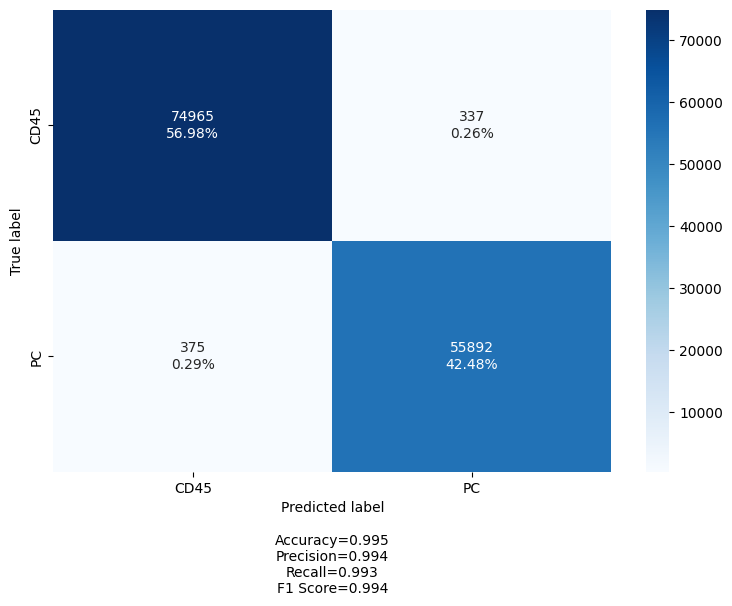

In [55]:
cats = list(all_model.classes_)
cm = confusion_matrix(all_y_test, all_y_test_pred, labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(9, 6))

## predict mars by spid annotations (and vice-versa)

#### data preperation

In [18]:
is_tme = "is_tme"
adata.obs[is_tme] = ((~adata.obs[label_col].isna()) & (adata.obs[label_col] != 'PC') & (adata.obs[super_pop] != 'PC')).astype("category")

In [19]:

hyper_class_dict = {
    'B' :['B', 'B_Pro'],
    'T' : ['T_Effector', 'T_Effector_GZMB', 'T_Naive', 'NK'],
    'M_DC' : ['DC','DC_IRF8', 'Mf', 'Mo', 'Mo_CD16'],
}

class_2_hyper_class_map = {}
for h_c, c_list in hyper_class_dict.items():
    for c in c_list:
        class_2_hyper_class_map[c] = h_c

def _map_class_to_hyper_class(cls_name, mapper=class_2_hyper_class_map):
    return  mapper[cls_name] if cls_name in mapper else cls_name
    
# list(set(map(_map_class_to_cyper_class, mars_model.classes_)))

In [20]:
adata.obs["hyper_population"] = adata.obs[label_col].apply(_map_class_to_hyper_class)

In [21]:
mars_adata = adata[(adata.obs['Method']=="MARS") & (adata.obs[is_tme].astype(bool))]
spid_adata = adata[(adata.obs['Method']=="SPID") & (adata.obs[is_tme].astype(bool))]

In [22]:
mars_X = mars_adata.obsm['X_scVI']
spid_X = spid_adata.obsm['X_scVI']

In [23]:
mars_y = mars_adata.obs[label_col]
spid_y = spid_adata.obs[label_col]

#### predict by random split

In [24]:
mars_X_train, mars_X_test, mars_y_train, mars_y_test = train_test_split(mars_X, mars_y, test_size=0.33, random_state=42)

In [25]:
mars_model = KNeighborsClassifier(n_neighbors=35)
mars_model.fit(mars_X_train, mars_y_train)
mars_y_test_pred = mars_model.predict(mars_X_test)

In [26]:
cats = list(set(map(_map_class_to_hyper_class, mars_model.classes_)))
cats.remove("UN")
cm = confusion_matrix(mars_y_test.apply(_map_class_to_hyper_class),
                      pd.Series(mars_y_test_pred).apply(_map_class_to_hyper_class),
                      labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

cats = list(mars_model.classes_)
cats.remove("UN")
cm = confusion_matrix(mars_y_test, mars_y_test_pred, labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

In [27]:
cm

array([[2742,   62,    1,    0,    0,    0,    0,    0,    2,    4,    1,
           0,    0,    0,    2,    1,   26,    1],
       [  30, 1067,    0,    2,    0,    0,    1,    0,    0,    0,    1,
           0,    0,    2,    3,    0,    4,    2],
       [   1,    0,  422,    4,    0,    0,    0,    0,   35,  249,  193,
           0,    0,    0,    1,    0,    2,    0],
       [   4,    1,   40,  200,    0,    0,    0,    0,    0,    7,    0,
           0,    0,    0,    0,    0,    3,    0],
       [   3,    0,    0,    0,  827,    0,    0,    0,    0,   11,    0,
           0,    1,    1,    1,    1,    2,    0],
       [   0,    0,    0,    0,    0,  197,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  179,    0,    0,    0,    0,
           0,    0,    0,    0,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    1,    0,    0,    0,    0,    0],


#### predict spid by mars

In [28]:
mars_model = KNeighborsClassifier(n_neighbors=35)
mars_model.fit(mars_X, mars_y)

KNeighborsClassifier(n_neighbors=35)

In [29]:
spid_y_pred = mars_model.predict(spid_X)

In [30]:
cats = list(set(map(_map_class_to_hyper_class, mars_model.classes_)))
cats.remove("UN")
cm = confusion_matrix(spid_y.apply(_map_class_to_hyper_class),
                      pd.Series(spid_y_pred).apply(_map_class_to_hyper_class),
                      labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

cats = list(mars_model.classes_)
cats.remove("UN")
cm = confusion_matrix(spid_y, spid_y_pred, labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

#### predict mars by spid

In [31]:
spid_model = KNeighborsClassifier(n_neighbors=35)
spid_model.fit(spid_X, spid_y)

KNeighborsClassifier(n_neighbors=35)

In [32]:
mars_y_pred = spid_model.predict(mars_X)

In [33]:
# predict origianl annotations (not hyper class anotations)

# cm = confusion_matrix(mars_y, mars_y_pred, labels=spid_model.classes_)
# make_confusion_matrix(cm , categories=spid_model.classes_, figsize=(16, 12))

In [34]:
cats = list(set(map(_map_class_to_hyper_class, spid_model.classes_)))
cats.remove("UN")
cm = confusion_matrix(mars_y.apply(_map_class_to_hyper_class),
                      pd.Series(mars_y_pred).apply(_map_class_to_hyper_class),
                      labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

cats = list(spid_model.classes_)
cats.remove("UN")
cm = confusion_matrix(mars_y, mars_y_pred, labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(14, 10))

# error analysis - annotation

#### tme classification error

In [35]:
is_tme_results_df = pd.DataFrame(index = all_y_test.index, data={"label": all_y_test.values, "pred": all_y_test_pred}) 
pc_predicted_as_tme = is_tme_results_df[(is_tme_results_df["label"]==False) & (is_tme_results_df["pred"]==True) ].index
len(pc_predicted_as_tme)

0

In [36]:
is_bad_pc = []
for i, row in adata.obs.iterrows():
    value = True if i in pc_predicted_as_tme else False
    is_bad_pc.append(value)
adata.obs["is_bad_pc"] = is_bad_pc
adata.obs["is_bad_pc"] = adata.obs["is_bad_pc"].astype('category')

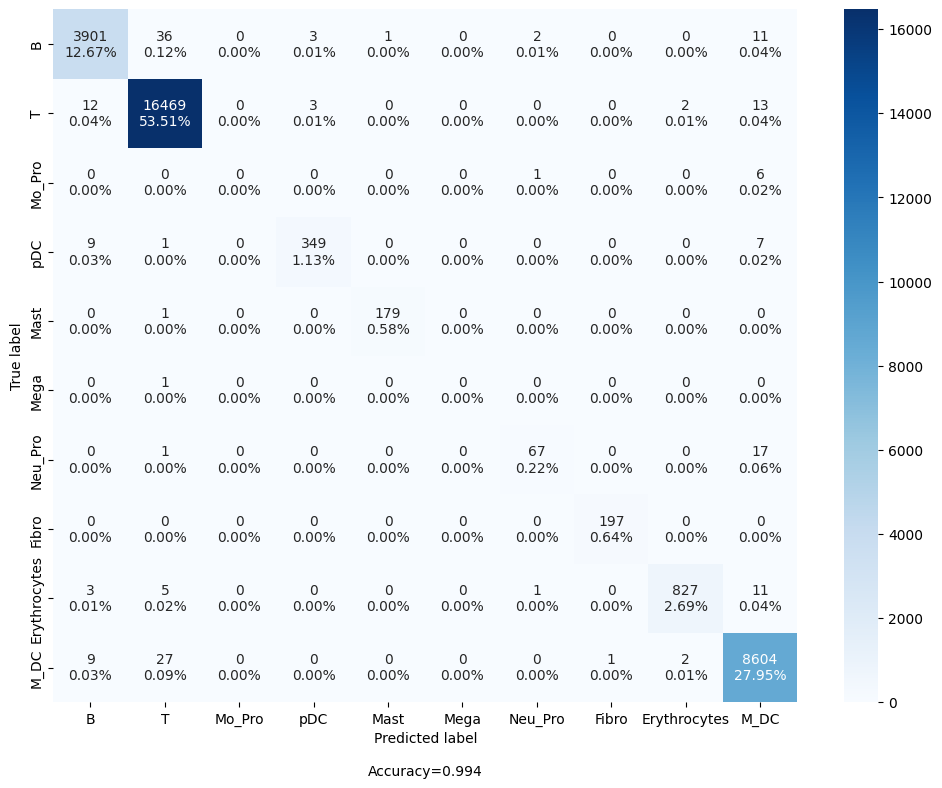

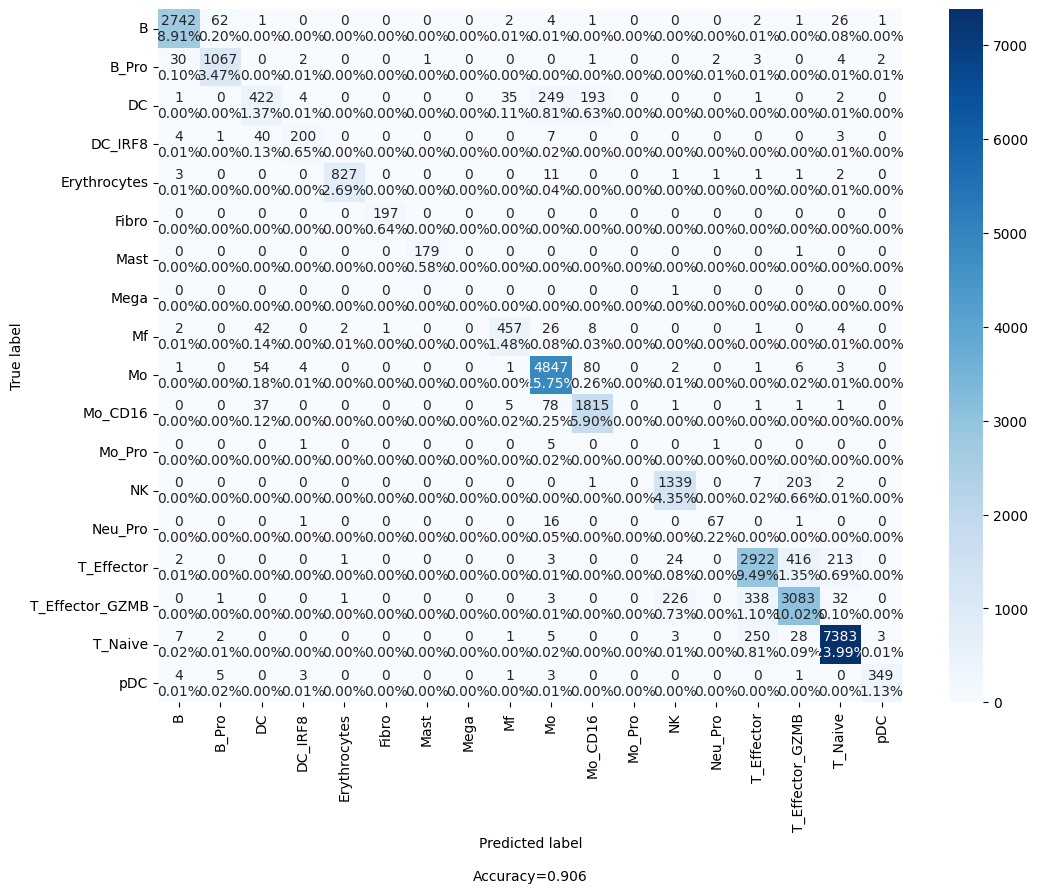

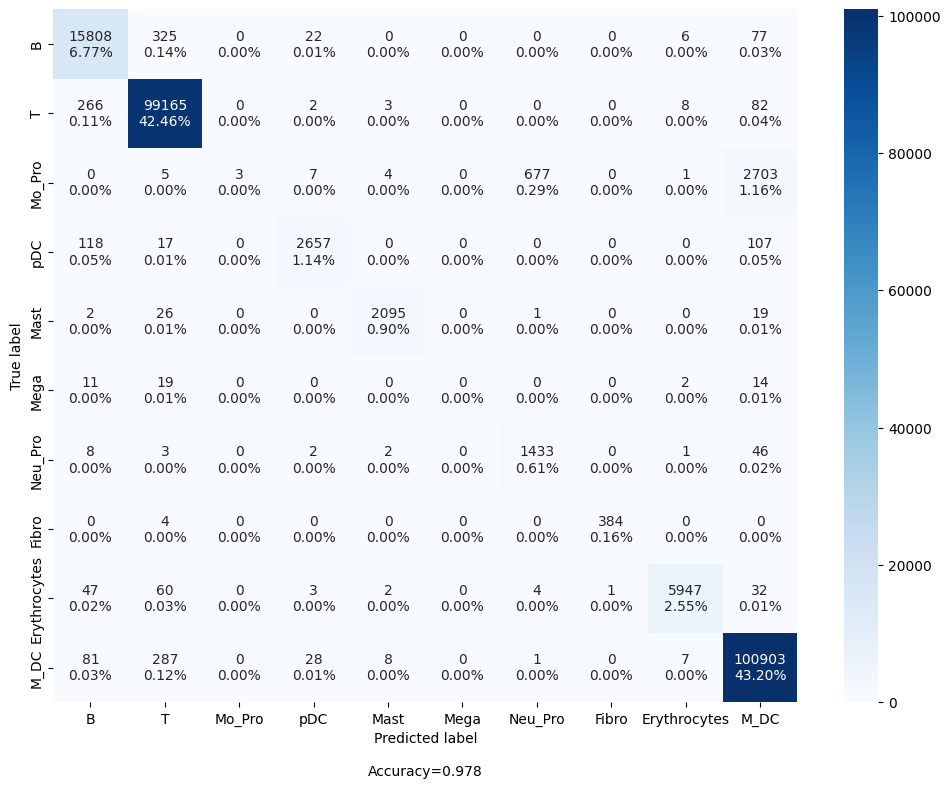

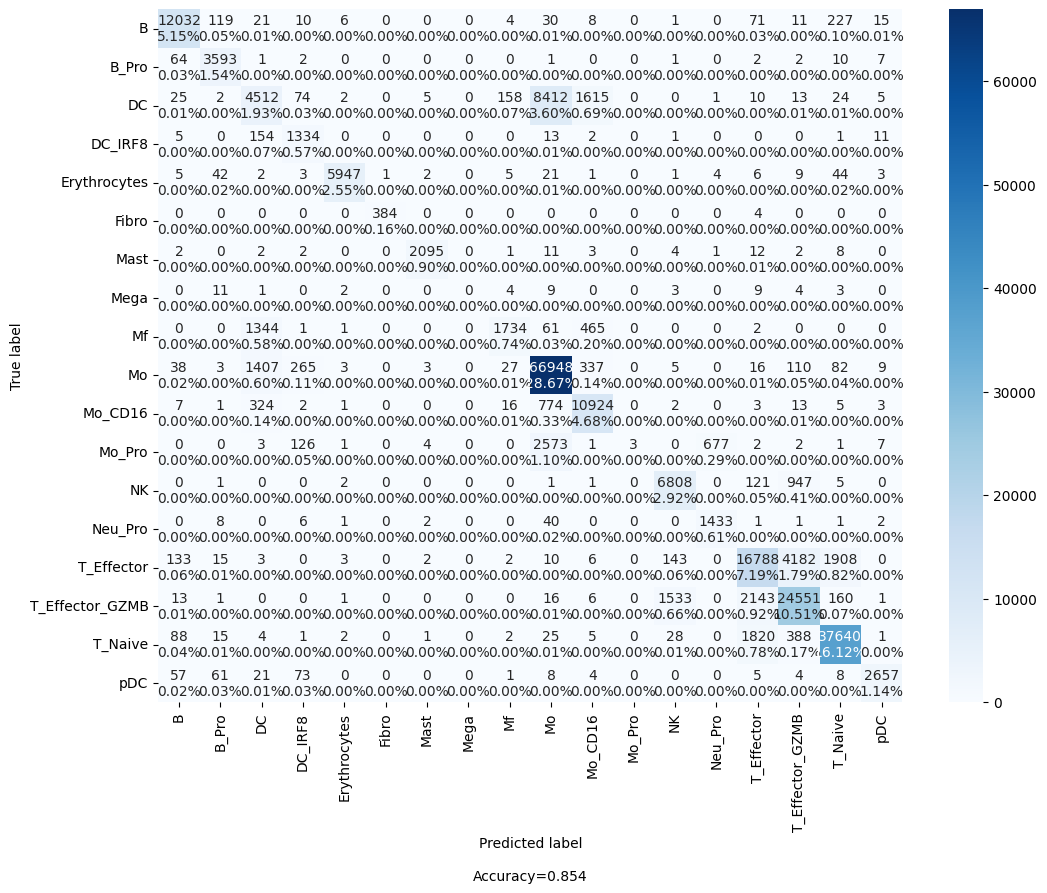

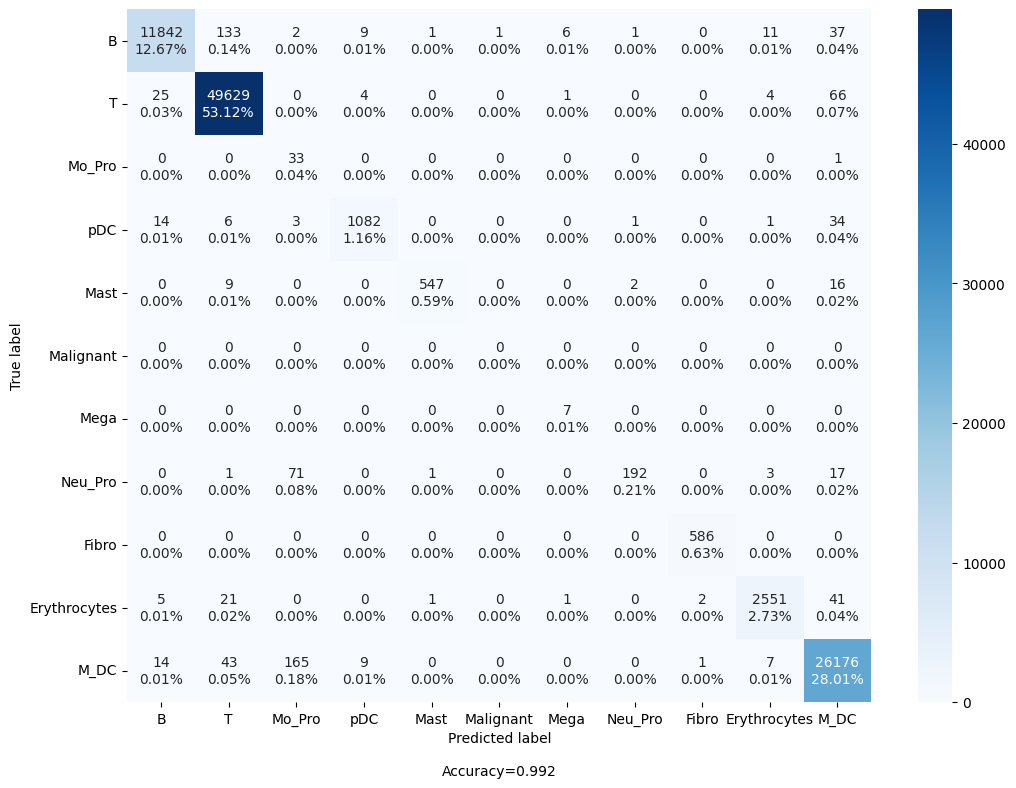

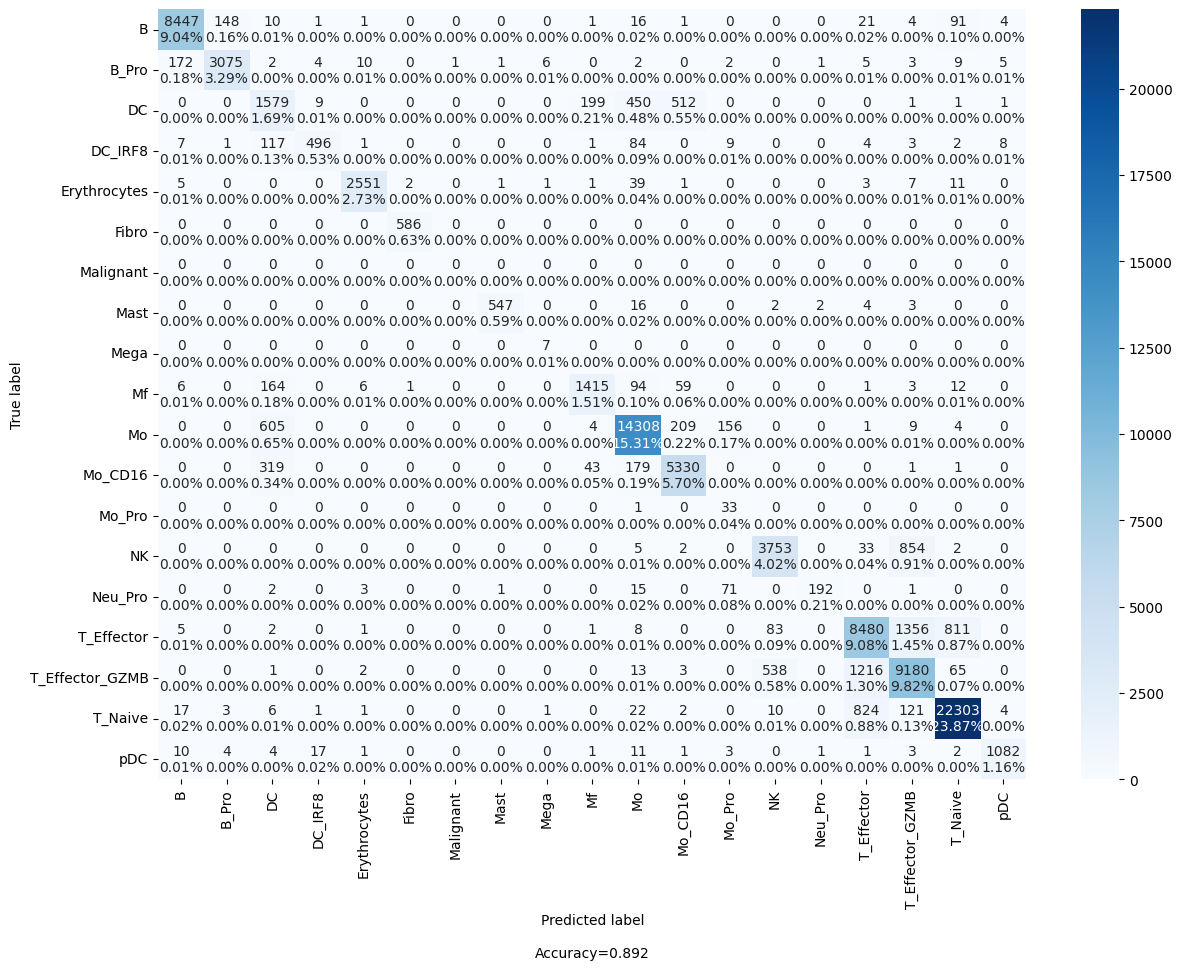

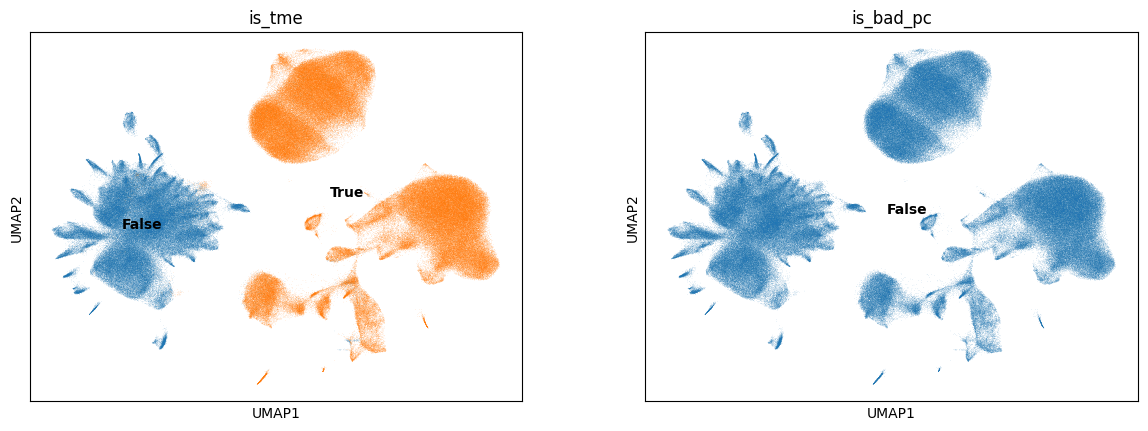

In [37]:
sc.pl.umap(adata, color=[is_tme, "is_bad_pc"],legend_loc="on data", ncols=2)

In [ ]:
sc.tl.embedding_density(adata, basis='umap', groupby='is_bad_pc')
sc.pl.embedding_density(adata, basis="umap", key='umap_density_is_bad_pc')

#### get mars B cells that are close to SPID T cells

In [ ]:

labels_hyper_class = mars_y.apply(_map_class_to_hyper_class)
pred_hyper_class = pd.Series(mars_y_pred).apply(_map_class_to_hyper_class)
results_df = pd.DataFrame(index = labels_hyper_class.index, data={"label": labels_hyper_class.values, "pred": pred_hyper_class.values})
bad_cells_mars = results_df[(results_df["label"] == "B") & (results_df["pred"] == "T")].index


In [ ]:

is_bad_mars = []
for i, row in adata.obs.iterrows():
    value = True if i in bad_cells_mars else False
    is_bad_mars.append(value)
adata.obs["bad_cells_mars"] = is_bad_mars
adata.obs["bad_cells_mars"] = adata.obs["bad_cells_mars"].astype('category')

#### get SPID T cells that are close to MARS B cells

In [ ]:

labels_hyper_class = spid_y.apply(_map_class_to_hyper_class)
pred_hyper_class = pd.Series(spid_y_pred).apply(_map_class_to_hyper_class)
results_df = pd.DataFrame(index = labels_hyper_class.index, data={"label": labels_hyper_class.values, "pred": pred_hyper_class.values})
bad_cells_spid = results_df[(results_df["label"] == "T") & (results_df["pred"] == "B")].index


In [ ]:

is_bad_spid = []
for i, row in adata.obs.iterrows():
    value = True if i in bad_cells_spid else False
    is_bad_spid.append(value)
adata.obs["bad_cells_spid"] = is_bad_spid
adata.obs["bad_cells_spid"] = adata.obs["bad_cells_spid"].astype('category')